# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [2]:
!ls pnp_dataset.zip || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip)

pnp_dataset.zip


In [3]:
# This configures the GPU to be used by Tensorflow.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import PIL.Image
from keras.applications.mobilenet import preprocess_input


def load_images(folder: str, limit: Optional[int] = None, preprocess: bool = True) -> np.ndarray:
    with zipfile.ZipFile('pnp_dataset.zip') as z:

        targets = sorted(p for p in z.namelist() if p.startswith(folder))
        if limit is not None:
            targets = targets[:limit]

        # Allocating an array for all images right away to avoid
        # storing images in a temporary Python list, which takes extra memory.
        images = np.empty((len(targets), 224, 224, 3), dtype=np.float16)

        for i, target in enumerate(targets):
            with z.open(target) as f:
                image_pixels = np.array(PIL.Image.open(f), dtype=np.float32)
                if preprocess:
                    image_pixels = preprocess_input(image_pixels)
                images[i] = image_pixels.astype(np.float16)
            
    return images

In [5]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
with zipfile.ZipFile('pnp_dataset.zip') as z:
    with z.open('pnp_dataset/train_y.npy') as f:
        train_y = np.load(f)

In [6]:
train_x.shape, train_y.shape,  train_x.dtype

((80000, 224, 224, 3), (80000,), dtype('float16'))

In [7]:
train_y[:5]

array([1, 0, 1, 1, 1])

1

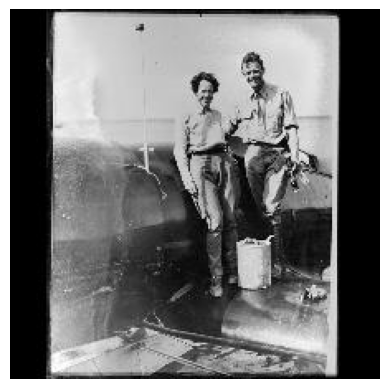

In [8]:
train_x_sample = load_images("pnp_dataset/train_x", limit=5, preprocess=False).astype(np.uint8)
plt.imshow(train_x_sample[0])
plt.axis('off')
train_y[0]

0

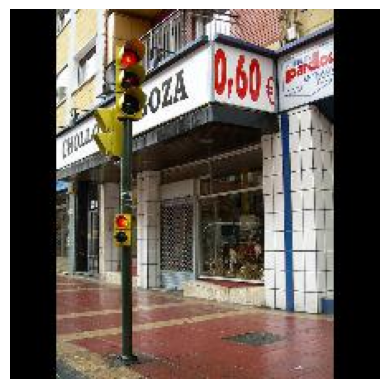

In [9]:
plt.imshow(train_x_sample[1])
plt.axis('off')
train_y[1]

# Data Split

In [10]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Determine the number of samples for each set
num_samples = len(train_x)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)

# Split the data without shuffling
train_x, val_x, test_x = train_x[:num_train], train_x[num_train:num_train + num_val], train_x[num_train + num_val:]
train_y, val_y, test_y = train_y[:num_train], train_y[num_train:num_train + num_val], train_y[num_train + num_val:]

In [11]:
train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape

((64000, 224, 224, 3),
 (8000, 224, 224, 3),
 (8000, 224, 224, 3),
 (64000,),
 (8000,),
 (8000,))

In [12]:

# # Calculate the number of samples for the validation set
# num_train = int(len(train_x) * 0.2)
# num_val = int(len(train_x) * 0.1)

# # Split the data into training and validation sets
# train_x, val_x = train_x[:-num_train], train_x[-num_train:]
# train_y, val_y = train_y[:-num_train], train_y[-num_train:]

# train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
# val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
# # test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)


In [13]:
with tf.device('/CPU:0'):
    train_x = tf.constant(train_x)
    train_y = tf.constant(train_y)
    val_x = tf.constant(val_x)
    val_y = tf.constant(val_y)
    test_x = tf.constant(test_x)
    test_y = tf.constant(test_y)
    score_x = tf.constant(score_x)

# Data Augmentation

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

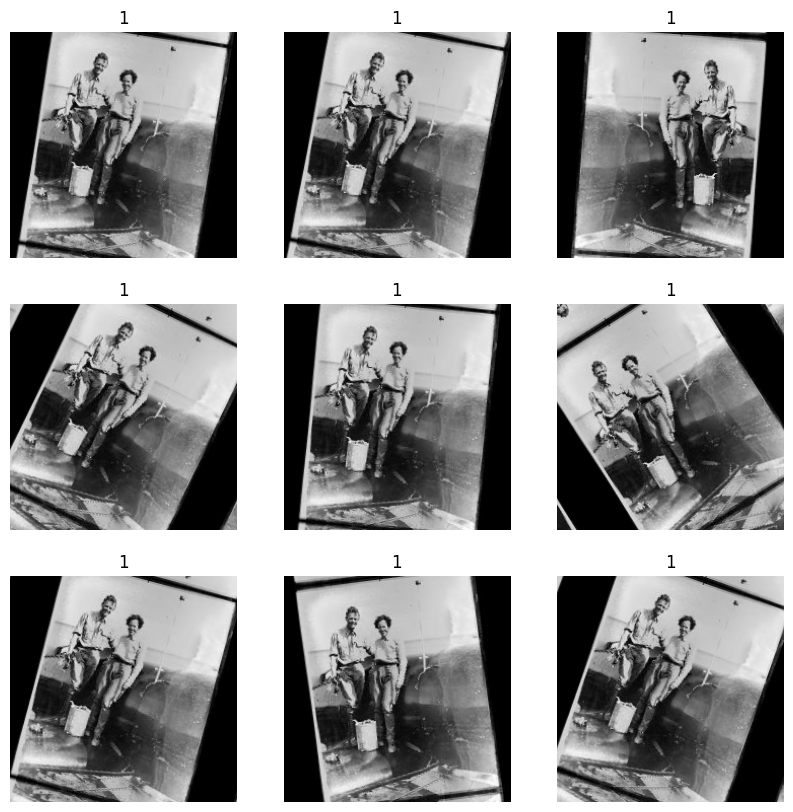

In [15]:
import tensorflow as tf

plt.figure(figsize=(10, 10))
first_image = train_x_sample[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(int(train_y[0]))
    plt.axis("off")

# Base Model

## mobile_net

In [16]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
)

# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
# mobile_net.summary()

## resnet50

In [18]:
resnet = tf.keras.applications.ResNet50(
include_top=False,
input_shape=(224, 224, 3),
weights='imagenet'
)

94781440/94765736 [==============================] - 2s 0us/step


In [19]:
resnet.trainable = False

# Model Development

* As the mlflow can't work normally, we manually check different models to choose the best hyper parameters.

In [20]:
import pandas as pd
def plot_learning_curve(history):
    learning_curve = pd.Series(history.history['loss'])
    learning_curve.index = learning_curve.index + 1

    learning_curve.plot(title='Learning Curve')
    plt.xticks(learning_curve.index)
    plt.show()

## Build model method

In [21]:
batch_size = 128
from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf

# def build_model(is_dense_added: bool, optimizer_index: int) -> tf.keras.Model:
    
    
#     mlflow.log_param('is_dense_added', is_dense_added)
#     mlflow.log_param('optimizer_index', optimizer_index)
#     if is_dense_added:
#         model = keras.models.Sequential([
#             mobile_net,
#             # data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(64, activation='relu'),
#             tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
#     else:
#          model = keras.models.Sequential([
#             mobile_net,
#             # data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
    
   
    # optimizer_options = [optimizers.Adam(0.001), 
#                          optimizers.RMSprop(0.001), 
#                          optimizers.SGD(0.001)
#                         ]
        
#     model.compile(
#         optimizer=optimizer_options[optimizer_index],
#         loss='binary_crossentropy',
#         metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#         ]
#     )

#     return model

## mobilenet with rmsprop

train: 0.8372656

val: 0.83619535

In [22]:
# from tensorflow import keras

# model = keras.models.Sequential([
#             mobile_net,
#             data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             # tf.keras.layers.Dense(128, activation='relu'),
#             # tf.keras.layers.Dropout(0.3),
#             # tf.keras.layers.Dense(64, activation='relu'),
#             # tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
# print(model.summary())

# model.compile(
#     optimizer='RMSprop',
#     loss='binary_crossentropy',
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#     ],
# )
# batch_size = 128

# history = model.fit(
#     train_x,
#     train_y,
#     epochs=2,
#     batch_size=batch_size
# )

In [23]:
def get_binary_accuracy(train_x, train_y, model):
    binary_accuracy = tf.keras.metrics.BinaryAccuracy()

    train_y_pred = model.predict(train_x, batch_size=batch_size)

# Update the metric with your data
    binary_accuracy.update_state(train_y, train_y_pred)


    print(binary_accuracy.result().numpy())

In [24]:
# binary_accuracy = tf.keras.metrics.BinaryAccuracy()

# train_y_pred = model.predict(train_x, batch_size=batch_size)

# # Update the metric with your data
# binary_accuracy.update_state(train_y, train_y_pred)


# binary_accuracy.result().numpy()

In [25]:
# val_y_pred = model.predict(val_x, batch_size=batch_size)

# binary_accuracy.update_state(val_y, val_y_pred)

# binary_accuracy.result().numpy()

In [26]:
# plot_learning_curve(history)

## mobilenet with adam

train: 0.5001094

val: 0.4938125

In [27]:
# model = keras.models.Sequential([
#             mobile_net,
#             data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             # tf.keras.layers.Dense(128, activation='relu'),
#             # tf.keras.layers.Dropout(0.3),
#             # tf.keras.layers.Dense(64, activation='relu'),
#             # tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
# print(model.summary())

# model.compile(
#     optimizer='Adam',
#     loss='binary_crossentropy',
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#     ],
# )
# batch_size = 128

# history = model.fit(
#     train_x,
#     train_y,
#     epochs=2,
#     batch_size=batch_size
# )

In [28]:
# get_binary_accuracy(train_x, train_y)
# get_binary_accuracy(val_x, val_y)

* No Adam optimizer

## Resnet with rmsprop

train: 0.8426875

test: 0.8395

164s per epoch

0.003 better than mobilenet with rmsprop

In [29]:
# model = keras.models.Sequential([
#             resnet,
#             data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             # tf.keras.layers.Dense(128, activation='relu'),
#             # tf.keras.layers.Dropout(0.3),
#             # tf.keras.layers.Dense(64, activation='relu'),
#             # tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
# print(model.summary())

# model.compile(
#     optimizer='RMSprop',
#     loss='binary_crossentropy',
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#     ],
# )
# batch_size = 128

# history = model.fit(
#     train_x,
#     train_y,
#     epochs=10,
#     batch_size=batch_size,
#     validation_data=(val_x, val_y)
    
# )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
______________________________________

KeyboardInterrupt: 

In [ ]:
plot_learning_curve(history)

In [ ]:
get_binary_accuracy(train_x, train_y, model)
get_binary_accuracy(val_x, val_y, model)
get_binary_accuracy(test_x, test_y, model)

## mobilenet with rmsprop and dense layers

train: 0.85403126

val:  0.851625

67s per epoch

In [ ]:
# model = keras.models.Sequential([
#             mobile_net,
#             data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(64, activation='relu'),
#             tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
# print(model.summary())

# model.compile(
#     optimizer='RMSprop',
#     loss='binary_crossentropy',
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#     ],
# )
# batch_size = 128

# history = model.fit(
#     train_x,
#     train_y,
#     epochs=2,
#     batch_size=batch_size
# )

In [ ]:
# get_binary_accuracy(train_x, train_y)

In [ ]:
# get_binary_accuracy(val_x, val_y)

In [ ]:
# plot_learning_curve(history)

## Resnet with rmsprop and dense layers

train: 0.53489065

test: 0.5261875

161s

In [ ]:
# model = keras.models.Sequential([
#             resnet,
#             data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(64, activation='relu'),
#             tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
# print(model.summary())

# model.compile(
#     optimizer='RMSprop',
#     loss='binary_crossentropy',
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#     ],
# )
# batch_size = 128

# history = model.fit(
#     train_x,
#     train_y,
#     epochs=2,
#     batch_size=batch_size
# )

In [ ]:
# get_binary_accuracy(train_x, train_y)
# get_binary_accuracy(val_x, val_y)

## Train model method

In [31]:
import json
import uuid
import os

# This function will be used to save each trained model.
# def save_model(model: tf.keras.Model, model_path: str):
#     os.makedirs(model_path, exist_ok=True)
#     tf.keras.models.save_model(model, f'{model_path}/model.keras')
#     with open(f'{model_path}/architecture.json', 'w') as f:
#         f.write(json.dumps(json.loads(model.to_json()), indent=True))


# # This function can be used to load a previously trained model.
# def load_model(model_path: str) -> tf.keras.Model:
#     return tf.keras.models.load_model(f'{model_path}/model.keras')

In [ ]:
# from collegium.foundation.callbacks import MlflowCallback
# import tempfile


# def train_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
#     history = model.fit(
#         x=train_x, 
#         y=train_y, 
        
#         epochs=epochs,
       
#         batch_size=128,
#         shuffle=False,
#         validation_data=(val_x, val_y),
#         callbacks=[MlflowCallback()],
#         verbose=verbose
#     )
    
#     # Save model parameters to the file system and upload to MLFlow.
#     with tempfile.TemporaryDirectory('wb') as d:
#         model_path = f'{d}/model'
#         save_model(model, model_path)
#         mlflow.log_artifacts(d)
    
#     return history

In [ ]:

# import mlflow
# mlflow.set_experiment('assignment_02')
# mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [ ]:
# mlflow.get_experiment_by_name('assignment_02')

In [ ]:
# model = keras.models.Sequential([
#     mobile_net,
#     keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
#     tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=1)
# ]
# )

# model.summary()

In [ ]:
# model = tf.keras.models.Sequential([
#     mobile_net,
#     tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=1)
# ])

In [ ]:
# model.summary()

# Hyperparameters training

In [ ]:
# is_dense_added = [False, False, False, True, True, True]
# optimizer_indices = [0, 1, 2, 0, 1, 2]

# parameters = list(zip(is_dense_added, optimizer_indices))
# parameters

In [ ]:
# import random
# import tqdm
# np.random.seed(11)
# tf.random.set_seed(11)

# # runs = 6
# # is_dense_added = [random.choice([False]) for _ in range(runs)]
# # optimizer_indices = [random.choice([0, 1, 2]) for _ in range(runs)]
# # is_dense_added = [False, True]
# # optimizer_indices = [0, 1, 2]

# # parameters = list(zip(is_dense_added, optimizer_indices))
# is_dense_added = [False, False, False, True, True, True]
# optimizer_indices = [0, 1, 2, 0, 1, 2]

# parameters = list(zip(is_dense_added, optimizer_indices))

# historys = []
# for (is_dense_added, optimizer_index) in tqdm.tqdm(parameters):
# # for  optimizer_index in optimizer_indices:   
#     with mlflow.start_run():
#         model = build_model(is_dense_added = is_dense_added, optimizer_index = optimizer_index)
#         history = train_model(model, epochs=10, verbose=0)
#         historys.append(history)

In [ ]:
# model.fit(
#     train_x,
#     train_y,
#     epochs=1,
#     batch_size=batch_size
# )

In [ ]:
# # Best run
# best_run = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name('assignment_02').experiment_id, 
#                              order_by=['metric.binary_crossentropy ASC']).iloc[0]


# saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(best_run['run_id'], 'model')
# model = load_model(saved_model_path)

# Fine Tuning (unfreeze the base model - optional)

In [ ]:
# np.random.seed(11)
# tf.random.set_seed(11)

# with mlflow.start_run():
#     history = train_model(model, epochs=20)

## not unfreeze

train: 0.85375

test: 0.852125

without unfreeze the model

In [ ]:
model1 = keras.models.Sequential([
            mobile_net,
            data_augmentation, # data augmentation
            # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

            tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
            tf.keras.layers.Flatten(),

            # add 2 more dense layers, can tune units, dropout rate, and if need them
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(units=1)
        ]
        )
print(model1.summary())

model1.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)
batch_size = 128

history1 = model1.fit(
    train_x,
    train_y,
    epochs=20,
    batch_size=batch_size,
    validation_data=(val_x, val_y)
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)              

In [33]:
get_binary_accuracy(train_x, train_y, model1)
get_binary_accuracy(val_x, val_y, model1)

0.8679531
0.85075


In [34]:
get_binary_accuracy(test_x, test_y, model1)

0.849875


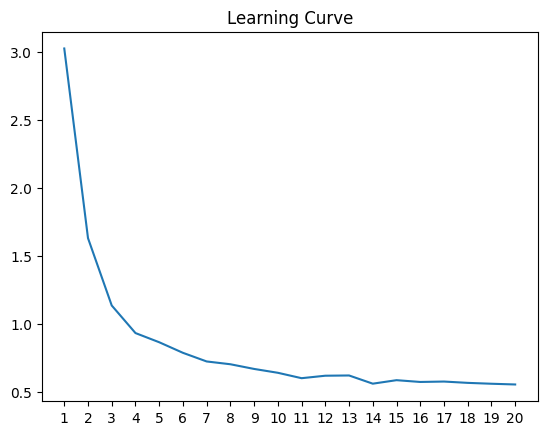

In [35]:
plot_learning_curve(history1)

### decrease learning rate

In [ ]:
# mmobile_netl = keras.models.Sequential([
#             mobile_net,
#             data_augmentation, # data augmentation
#             # keras.layers.Rescaling(scale=1 / 127.5, offset=-1), # rescale data

#             tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
#             tf.keras.layers.Flatten(),

#             # add 2 more dense layers, can tune units, dropout rate, and if need them
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(64, activation='relu'),
#             tf.keras.layers.Dropout(0.3),

#             tf.keras.layers.Dense(units=1)
#         ]
#         )
# print(model.summary())

# model.compile(
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
#     loss='binary_crossentropy',
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(
#             name="binary_accuracy",
#             threshold=0.5
#         )
#     ],
# )
# batch_size = 128

# history = model.fit(
#     train_x,
#     train_y,
#     epochs=20,
#     batch_size=batch_size
# )



In [ ]:
# get_binary_accuracy(train_x, train_y)
# get_binary_accuracy(val_x, val_y)

In [ ]:
# plot_learning_curve(history)

## Unfreeze the model

In [46]:

# for layer in mobile_net.layers[:100]:
    # layer.trainable = True
    
for i in range(100):
    mobile_net.get_layer(index=i).trainable = True

# mobile_net.trainable = True
inputs = keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs) 
x = inputs

x = mobile_net(x, training=False)
x = keras.layers.AvgPool2D(pool_size=(5,5))(x)

# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1)(x)
model2 = keras.Model(inputs, outputs)
print(model2.summary())

model2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)
batch_size = 128

history2 = model2.fit(
    train_x,
    train_y,
    epochs=12,
    batch_size=batch_size,
    validation_data=(val_x, val_y)
)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_5 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 dense_7 (Dense)             (None, 1, 1, 1)           1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/12
500/500 [====================

KeyboardInterrupt: 

In [ ]:
get_binary_accuracy(train_x, train_y, model2)
get_binary_accuracy(val_x, val_y, model2)
get_binary_accuracy(test_x, test_y, model2)

In [ ]:
plot_learning_curve(history2)

# Inference

In [36]:
import os 
import pandas as pd

model_dir = 'pnp_model'

# can change model later
model = model1

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/model_architecture.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
tf.keras.models.save_model(model, f'{model_dir}/model.keras')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. model_architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset